In [ ]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision import transforms as T
from glob import glob
from tqdm import tqdm
import albumentations as A
import numpy as np
import torch.nn.functional as F
from torchsummary import summary
import seaborn as sns
from albumentations.pytorch import ToTensorV2
from PIL import Image
from google.colab.patches import cv2_imshow
import pandas as pd
import os
torch.manual_seed(0)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Img_size = 256
batch_size = 20
pin_memory = True
num_workers = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

class Transforms:
    def __init__(self):
        self.transforms = A.Compose(
    [
        A.Resize(Img_size, Img_size),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # A.augmentations.dropout.cutout.Cutout(6),
        ToTensorV2(),
    ]
)

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img, np.float32))['image']


In [ ]:
def Otsu(img):
    mean = img.mean()
    img[img < mean] = 0
    img[img > mean] = 1
    return img

transforms = T.Compose(
    [T.ToTensor(),
        T.Resize((Img_size, Img_size)),
        T.RandomRotation(20),
     T.RandomErasing(scale=(0.02, 0.1)),
     Otsu
    ])
class Testdata(Dataset):
    def __init__(self, directory, transforms):
      self.files = glob(directory)
      self.transform = transforms
      self.dir = directory
    def __len__(self):
      return len(self.files)
    def __getitem__(self, index):
      file = self.files[index]
      img = Image.open(os.path.join(self.dir, file)).convert('RGB')
      img = self.transform(img)
      return img, file

full_dataset = ImageFolder(r"/content/drive/MyDrive/SCTL/Train", transform = transforms)
test_ds = Testdata("/content/drive/MyDrive/SCTL/Test/Test/*.jpg", transforms= transforms)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
test_dl = DataLoader(test_ds, batch_size=batch_size, pin_memory=pin_memory)

for img, lbl in train_dl:
  break

[0.6083551  0.5726719  0.83724976 0.98172325]


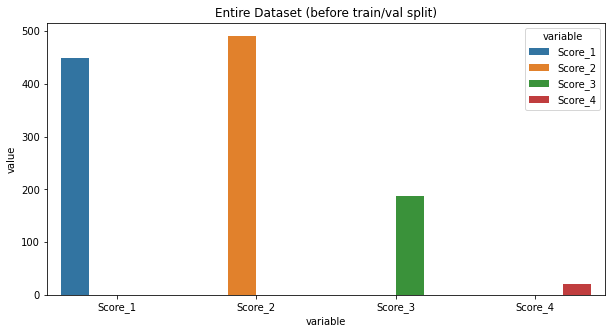

In [ ]:
idx2class = {v: k for k, v in full_dataset.class_to_idx.items()}
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable").set_title(plot_title)
plt.figure(figsize=(10,5))
class_dist = get_class_distribution(full_dataset)
plot_from_dict(class_dist, plot_title="Entire Dataset (before train/val split)")

# Inverse class weights
inverse_cls_dist = 1 - np.array(list(class_dist.values()), dtype=np.float32)/len(full_dataset)
print(inverse_cls_dist)

In [ ]:
class CNN_regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential( #3x256x256
      nn.Conv2d(3, 8, 3, stride=2),
      nn.Conv2d(8, 8, 3, stride=2),
      nn.Conv2d(8, 16, 3, stride=2),
      nn.Conv2d(16, 16, 3, stride=2, padding=1),
      )
    
  def forward(self, img):
    return self.model(img)

regressor = CNN_regressor()
regressor(img).shape


torch.Size([20, 16, 16, 16])

In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), return_indices=True),
    )
  def forward(self, img):
    return self.encoder(img)


class CompleteAC(CNN_regressor):
  def __init__(self):
    super().__init__()
    # super(CNN_regressor, self).__init__()
    # self.latent_space = latent_space
    # self.relu = nn.ReLU()
    self.encoder = nn.Sequential( 
        nn.Conv2d(in_channels=3, out_channels = 16, kernel_size = 3, stride= 2, padding=1),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size = (2, 2), stride=(2, 2), return_indices=True),
    )
    self.encoder1 = nn.Sequential( 
        nn.Conv2d(in_channels=16, out_channels = 16, kernel_size = 3, stride= 2, padding=1),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size = (2, 2), stride=(2, 2), return_indices=True)
    )
    self.encoder2 = nn.Sequential( 
        nn.Conv2d(in_channels=16, out_channels = 16, kernel_size = 3, stride= 2, padding=1),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size = (2, 2), stride=(2, 2), return_indices=True)
    )
    self.unmax = nn.MaxUnpool2d(kernel_size = (2, 2), stride=(2, 2), padding=0)
    self.encoderLinear = nn.Linear(16*16*16, 2000)
    self.encoderLinear1 = nn.Linear(2000, 4)
    self.deoderLinear = nn.Linear(4, 2000)
    self.decoderLinear1 = nn.Linear(2000, 16*16*16)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=16, out_channels = 16, kernel_size = 3, stride=2, padding=1, output_padding=1),
    )
    self.decoder1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=16, out_channels = 16, kernel_size = 3, stride=2, padding=1, output_padding=1),
        nn.Softmax(dim=1)
    )
    self.decoder2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=16, out_channels = 3, kernel_size = 3, stride=2, padding=1, output_padding=1),
        nn.Softmax(dim=1)
    )


  def forward(self, img):
    # Encoder block
    latent, indices = self.encoder(img)
    out = self.unmax(latent, indices)
    latent1, indices1 = self.encoder1(out)
    out = self.unmax(latent1, indices1)
    regressor = self.model(img)
    latent2, indices2 = self.encoder2(out)
    regressor_latent = (regressor + latent2)/2
    out = self.unmax(regressor_latent, indices2) 
    # Decoder blocks
    # latent3 = self.encoder(out.flatten())
    out = self.decoder(out)
    out = self.decoder1(out)
    return regressor_latent, self.decoder2(out) 

AE_model = CompleteAC().to(device)
latent, out = AE_model(img.to(device))
latent.shape, out.shape

(torch.Size([20, 16, 16, 16]), torch.Size([20, 3, 256, 256]))

In [ ]:
class CompleteAC(nn.Module):
  def __init__(self):
    super().__init__()
    # self.latent_space = latent_space
    self.encoder = nn.Sequential( # Image size Nx3x410x410
        nn.Conv2d(in_channels=3, out_channels = 16, kernel_size = 3, stride= 2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(), # Img size 16x136x136
        nn.Conv2d(in_channels=16, out_channels = 32, kernel_size = 3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(), # Img size 16x44x44
        nn.Conv2d(in_channels=32, out_channels = 64, kernel_size = 3, stride=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(), # Img size 64x11x11
        nn.Conv2d(in_channels=64, out_channels = 64, kernel_size = 3, stride=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.maxpool = nn.MaxPool2d(3, 1, 1)
    self.unmaxpool = nn.MaxUnpool2d(3, 1, 1)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels = 64, kernel_size = 3, stride=3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=64, out_channels = 32, kernel_size = 3, stride=3, padding=1, output_padding=1),
        nn.ReLU(),
        # nn.MaxUnpool2d(kernel_size = (2, 2), stride=(2, 2)),
        nn.ConvTranspose2d(in_channels=32, out_channels = 16, kernel_size = 3 , stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        # nn.MaxUnpool2d(kernel_size = (2, 2), stride=(2, 2)),
        nn.ConvTranspose2d(in_channels=16, out_channels = 3, kernel_size = 3, stride=2, padding=1, output_padding=1),
        nn.Softmax(dim=1)
    )
  def forward(self, img):
    latent = self.encoder(img)
    return latent, self.decoder(latent)

AE_model = CompleteAC().to(device)
AE_model(img.to(device)).shape

AttributeError: ignored

In [ ]:
# train_dl = DataLoader(full_dataset, batch_size=5, pin_memory=pin_memory, shuffle=True)
for img, lbls in train_dl:
  latent, out = AE_model(img.to(device))
  break
model = AE_model
latent.shape, out.shape

(torch.Size([20, 16, 16, 16]), torch.Size([20, 3, 256, 256]))

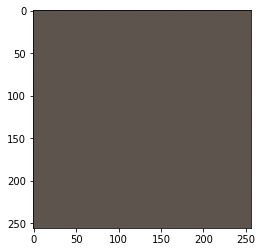

In [ ]:
plt.imshow(out[0].detach().cpu().swapaxes(0, 2))

# Training regressor

In [ ]:
model = AE_model
num_epochs = 15
learning_rate = 1e-2
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
ceLoss = nn.CrossEntropyLoss()
mse = nn.MSELoss() 
training_loss = []
valid_loss = []
valid_acc = []
train_acc = []
latent_features = []


for epoch in range(num_epochs):
# Training loop
    model.train(True)
    correct = 0
    for X, y in tqdm(train_dl):  
        X, y = X.to(device), y.to(device)
        opt.zero_grad()
        latent, yhat = model(X)
        # yhat = model(X) 
        # loss = mse(yhat, X)*0.4 + ceLoss(yhat, X) * 0.6
        loss = mse(yhat, X)
        # Apply backprop 
        loss.backward() 
        opt.step() 
    training_loss.append(loss.item())
    
    print(f"Epoch {epoch}: training loss is {loss.item()}")
    
    model.eval()

# Valid loop
    correct = 0
    for batch in tqdm(valid_dl):
        X, y = batch 
        X, y = X.to(device), y.to(device) 
        latent, yhat = model(X)
        # yhat = model(X) 
        loss = mse(yhat, X)
        # loss = mse(yhat, X)*0.4 + ceLoss(yhat, X) * 0.6

         
    print(f"Epoch {epoch}: valid loss is {loss.item()}")
    valid_loss.append(loss.item())

100%|██████████| 46/46 [00:14<00:00,  3.22it/s]


Epoch 0: training loss is 0.24733778834342957


100%|██████████| 12/12 [00:03<00:00,  3.24it/s]


Epoch 0: valid loss is 0.22685645520687103


100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


Epoch 1: training loss is 0.22590507566928864


100%|██████████| 12/12 [00:03<00:00,  3.35it/s]


Epoch 1: valid loss is 0.2178400605916977


100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


Epoch 2: training loss is 0.2091185301542282


100%|██████████| 12/12 [00:03<00:00,  3.77it/s]


Epoch 2: valid loss is 0.19704021513462067


100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


Epoch 3: training loss is 0.21790802478790283


100%|██████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch 3: valid loss is 0.21953371167182922


100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


Epoch 4: training loss is 0.22121283411979675


100%|██████████| 12/12 [00:03<00:00,  3.50it/s]


Epoch 4: valid loss is 0.21346719563007355


100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


Epoch 5: training loss is 0.21424739062786102


100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


Epoch 5: valid loss is 0.2142540067434311


100%|██████████| 46/46 [00:13<00:00,  3.32it/s]


Epoch 6: training loss is 0.2184825837612152


100%|██████████| 12/12 [00:03<00:00,  3.58it/s]


Epoch 6: valid loss is 0.21298129856586456


100%|██████████| 46/46 [00:14<00:00,  3.09it/s]


Epoch 7: training loss is 0.20509417355060577


100%|██████████| 12/12 [00:03<00:00,  3.80it/s]


Epoch 7: valid loss is 0.22788752615451813


100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


Epoch 8: training loss is 0.20099744200706482


100%|██████████| 12/12 [00:03<00:00,  3.74it/s]


Epoch 8: valid loss is 0.21221986413002014


100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


Epoch 9: training loss is 0.208070769906044


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


Epoch 9: valid loss is 0.20652349293231964


100%|██████████| 46/46 [00:13<00:00,  3.31it/s]


Epoch 10: training loss is 0.2130240499973297


100%|██████████| 12/12 [00:03<00:00,  3.26it/s]


Epoch 10: valid loss is 0.2078007161617279


100%|██████████| 46/46 [00:14<00:00,  3.09it/s]


Epoch 11: training loss is 0.2032022625207901


100%|██████████| 12/12 [00:03<00:00,  3.74it/s]


Epoch 11: valid loss is 0.23096860945224762


100%|██████████| 46/46 [00:13<00:00,  3.39it/s]


Epoch 12: training loss is 0.20781241357326508


100%|██████████| 12/12 [00:03<00:00,  3.76it/s]


Epoch 12: valid loss is 0.2276863157749176


100%|██████████| 46/46 [00:13<00:00,  3.37it/s]


Epoch 13: training loss is 0.21363142132759094


100%|██████████| 12/12 [00:03<00:00,  3.76it/s]


Epoch 13: valid loss is 0.21624267101287842


100%|██████████| 46/46 [00:13<00:00,  3.31it/s]


Epoch 14: training loss is 0.2074694037437439


100%|██████████| 12/12 [00:04<00:00,  2.98it/s]

Epoch 14: valid loss is 0.1952235996723175


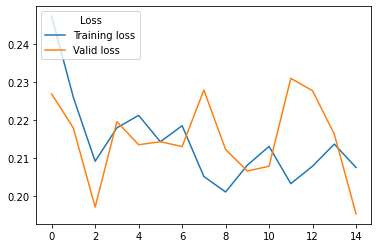

In [ ]:
plt.plot(training_loss, label='Training loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend(loc='upper left', title='Loss');

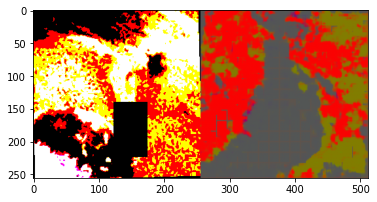

In [ ]:
for img, lbl in train_dl:
  out = model(img.to(device))
  latent, outimg = out[0][0], out[1][1]
  latent_features.append(latent)
  break

plt.imshow(np.hstack([img[0].cpu().swapaxes(0, 2), outimg.detach().cpu().swapaxes(0, 2)]))


### Creating training and testing features

In [ ]:
train_features  = []
lbls = []
for img, lbl in train_dl:
  latent, out = model(img.to(device))
  lbls.extend(lbl.flatten().tolist() )
  train_features.extend(latent.flatten(start_dim=1).tolist())

test_features  = []
files = [] 
for img, file in test_dl:
  latent, out = model(img.to(device))
  files.extend(list(file) )
  test_features.extend(latent.flatten(start_dim=1).tolist())

In [ ]:
pd.DataFrame({"Image features": train_features, "class": lbls}).head()

,Image features,class
0,"[-0.5427229404449463, -0.5759631991386414, -0....",1
1,"[-0.47104331851005554, 2.053551197052002, -0.1...",1
2,"[1.3210382461547852, 2.128032684326172, 1.3659...",1
3,"[-0.3602038025856018, 1.9453554153442383, 2.59...",0
4,"[-0.42546939849853516, -0.37368685007095337, -...",2


In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4).fit(train_features, lbls)
knn_preds = knn.predict(test_features)
svc = SVC().fit(train_features, lbls)
svc_preds = svc.predict(test_features)

# SVC test accuracy

In [ ]:
submission = pd.DataFrame({'File': files, "Pred": svc_preds})
submission.File = submission.File.apply(lambda x: x.split("/")[-1])
submission.to_csv("AE_SVC_submission.csv", index=False, header=None)

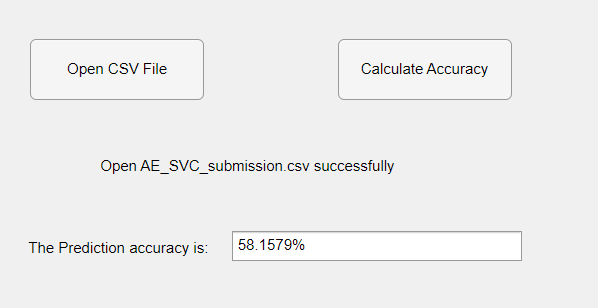

# KNN test accuracy

In [ ]:
submission = pd.DataFrame({'File': files, "Pred": knn_preds})
submission.File = submission.File.apply(lambda x: x.split("/")[-1])
submission.to_csv("AE_KNN_submission.csv", index=False, header=None)

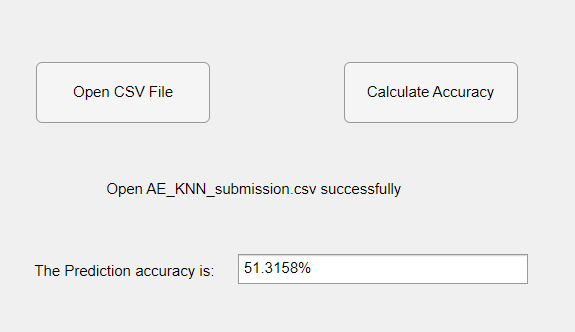

# Using Pre-trained model


In [ ]:
import torchvision
from torchvision import models 
pretrained_model = torchvision.models.resnet50(pretrained=True)
class ResNet50_Linear(nn.Module):
    def __init__(self, pretrained_model):
        super(ResNet50_Linear, self).__init__()
        self.pretrained = pretrained_model
        self.new_layers = nn.Sequential(nn.Linear(1000, 100),
                                           nn.ReLU(),
                                           nn.Linear(100, 4))
        
    def forward(self, x):
        x = self.pretrained(x)
        x = self.new_layers(x)
        return x

model = ResNet50_Linear(pretrained_model=pretrained_model).to(device)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, reduction='sum'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.weight is not None:
            focal_loss = focal_loss * self.weight

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [ ]:
num_epochs = 15
learning_rate = 0.001
# clf = stackedm
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss1 = nn.CrossEntropyLoss(weight=torch.tensor(inverse_cls_dist).to(device))
loss1 = nn.CrossEntropyLoss() 
# criterion = nn.NLLLoss()
loss2 = FocalLoss(gamma=2.5) # Focal loss is used to calculate loss when the dataset is imbalanced
training_loss = []
valid_loss = []
valid_acc = []
train_acc = []

the_last_loss = 100
patience = 2
trigger_times = 0

best_accuracy = 0.2
for epoch in range(1, num_epochs+1):
# Training loop
    model.train(True)
    correct = 0
    for X, y in tqdm(train_dl):  
        X, y = X.to(device), y.to(device) 
        opt.zero_grad()
        yhat = model(X) 
        loss = (loss1(yhat, y)*0.4) + (loss2(yhat, y)*0.6)
        # Apply backprop 
        loss.backward()
        opt.step() 
        correct += (torch.argmax(yhat, dim=1) == y).float().sum().detach().cpu()
    accuracy = 100 * correct / len(train_dataset)
    train_acc.append(accuracy)    
    training_loss.append(loss.item())
    print(f"Epoch:{epoch} training accuracy is {accuracy}")
    print(f"Epoch:{epoch} training loss is {loss.item()}")
    
    model.train(False)

    # Valid loop
    correct = 0
    with torch.no_grad():
        for X, y in tqdm(valid_dl): 
            X, y = X.to(device), y.to(device) 
            yhat = model(X) 
            loss = (loss1(yhat, y)*0.4) + (loss2(yhat, y)*0.6) 
            correct += (torch.argmax(yhat, dim=1) == y).float().sum().detach().cpu()
        accuracy = 100 * correct / len(valid_dataset)
        valid_acc.append(accuracy)
        valid_loss.append(loss.item())    
        print(f"Epoch:{epoch} valid accuracy is {accuracy}") 
        print(f"Epoch:{epoch} valid loss is {loss.item()}")

        if accuracy > best_accuracy:
          best_accuracy = accuracy
          torch.save(model.state_dict(), f"model_{accuracy}_.pt")
    # Early stopping
    if loss > the_last_loss:
      trigger_times += 1
    if trigger_times > 0 and loss < the_last_loss:
      trigger_times -= 1
    if trigger_times == patience:
      break
    the_last_loss = loss
    print("Trigger: ", trigger_times)
    print("-"*50)
print("Training complete")

In [ ]:
plt.plot(training_loss,label='Training loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend(loc='upper left', title='Loss');

In [ ]:
plt.plot(valid_acc, label='Valid accuracy')
plt.plot(train_acc, label='Train accuracy')
plt.legend(loc='upper left', title='Accuracy');

In [ ]:
train_features  = []
lbls = []
for img, lbl in train_dl:
  out= model(img.to(device))
  lbls.extend(lbl.flatten().tolist() )
  train_features.extend(out.flatten(start_dim=1).tolist())

test_features  = []
files = [] 
for img, file in test_dl:
  out = model(img.to(device))
  files.extend(list(file) )
  test_features.extend(out.flatten(start_dim=1).tolist())

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4).fit(train_features, lbls)
knn_preds = knn.predict(test_features)

svc = SVC().fit(train_features, lbls)
svc_preds = svc.predict(test_features)

# SVC test accuracy

In [ ]:
submission = pd.DataFrame({'File': files, "Pred": svc_preds})
submission.File = submission.File.apply(lambda x: x.split("/")[-1])
submission.to_csv("ResNet_svc_submission.csv", index=False, header=None)

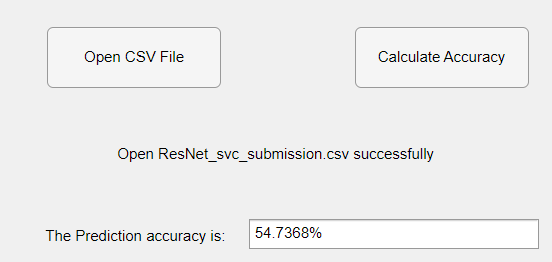

# KNN test accuracy

In [ ]:
submission = pd.DataFrame({'File': files, "Pred": knn_preds})
submission.File = submission.File.apply(lambda x: x.split("/")[-1])
submission.to_csv("ResNet_KNN_submission.csv", index=False, header=None)

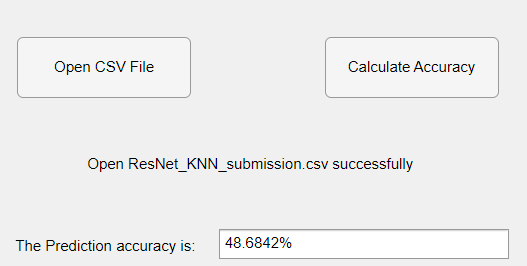